# JB1 Projecting Antenna Patterns to Earth 

This notebook describes the process to projecting an antenna pattern to Earth, a crucial step in multiple algortihms provided in the RGB. This notebook provides a general method, which is been adapted to fit the needs of the RGB in the `AntennaPattern` and `GaussianAntennaPattern` modules of the RGB. 

**References**:

[R1] - [SMAP Ancilliary Data Product](https://nsidc.org/sites/default/files/smap_anc_l1l3l4.pdf)   
[R2] - [SMAP Spacecraft Frames Definition Kernel](https://naif.jpl.nasa.gov/pub/naif/SMAP/kernels/fk/smap_pf_v14.tf)   
[R3] - [SMAP L1b Product Specification Document](https://nsidc.org/sites/default/files/smap_radiometer_level_1b_tb_product20specification20document_1805b15d.pdf)

**Data**:

[D1] - [SMAP Antenna Patterns](https://urs.earthdata.nasa.gov/oauth/authorize?client_id=_JLuwMHxb2xX6NwYTb4dRA&response_type=code&redirect_uri=https%3A%2F%2Fn5eil01u.ecs.nsidc.org%2FOPS%2Fredirect&state=aHR0cHM6Ly9uNWVpbDAxdS5lY3MubnNpZGMub3JnL1NNQVBfQU5DL1NNQVBfTDFfTDNfQU5DX1NUQVRJQy4wMDEvMjAxNi4xMi4wNy9SYWRpb21ldGVyQW50UGF0dGVybl8xNzA4MzBfdjAxMS5oNQ)  
[D2] - [SMAP L1b File](https://urs.earthdata.nasa.gov/oauth/authorize?client_id=_JLuwMHxb2xX6NwYTb4dRA&redirect_uri=https%3A%2F%2Fn5eil01u.ecs.nsidc.org%2FOPS%2Fredirect&response_type=code&state=aHR0cHM6Ly9uNWVpbDAxdS5lY3MubnNpZGMub3JnL0RQNC9TTUFQL1NQTDFCVEIuMDA1LzIwMjMuMTIuMDEvU01BUF9MMUJfVEJfNDcxODVfRF8yMDIzMTIwMVQyMTIxMjBfUjE4MjkwXzAwMS5oNQ)

In [1]:
# Import relevant modules. 
import pathlib as pb

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.tri as tri
import h5py
from pyproj import CRS, Transformer
import cartopy.crs as ccrs
import cartopy.feature as cfeature

import cimr_grasp.grasp_io as grasp_io

## Step 1 - Opening the antenna patterns

We begin with the SMAP antenna patterns, for which we have based the general format of the RGB antenna patterns on. That is, we have created another module called "CIMR-GRASP", which transforms the raw antenna patterns into the same format as the SMAP antenna patterns. This format is HDF5, and the SMAP antenna patterns can be downloaded from reference [D1]. The patterns are described in [R1], at the end of page 6. 

The patterns are provided in a spherical coordinate system, with a 0.1&deg; resolution and [0&deg;<=&phi;<=360&deg;], [0&deg;<=&theta;<=180&deg;].

![Spherical Coordinate System](Images/spherical_coordinate_system.png)

As you will see from the antenna pattern subscription, there are many componenents of the antenna patterns, for the rest of the notebook, we will focus on the "G1h" component and the first step is to transform the antenna patterns from a spherical coordiante system to a cartesian one, described in the code block below. In addition the code is cut down to the region only around the main beam, this can be performeed by setting limits on phi_range and theta_range as outlined below. 


In [2]:
# Insert the path to the downloaded SMAP Antenna pattern below
root_path = grasp_io.find_repo_root()

antenna_file_path = root_path.joinpath("dpr/antenna_patterns/SMAP/RadiometerAntPattern_170830_v011.h5")
l1b_file_path = root_path.joinpath('dpr/L1B/SMAP/SMAP_L1B_TB_47185_D_20231201T212120_R18290_001.h5')

# function to get the antenna patterns in (x,y,z) coordinates
def get_antenna_patterns(antenna_file, gain_label, phi_range=None, theta_range=None, threshold=None):

    with h5py.File(antenna_file_path, 'r') as f:
        gains = f['Gain'][gain_label][:].flatten()
        phi   = f['Grid']['phi'][:]
        theta = f['Grid']['theta'][:]
        theta, phi = np.meshgrid(theta, phi)
        theta = theta.flatten()
        phi   = phi.flatten()
        
        if phi_range is not None:
            mask = np.logical_and(phi > phi_range[0], phi < phi_range[1])
            phi = phi[mask]
            theta = theta[mask]
            gains = gains[mask]

        if theta_range is not None:
            mask = np.logical_and(theta > theta_range[0], theta < theta_range[1])
            phi = phi[mask]
            theta = theta[mask]
            gains = gains[mask]

        if threshold is not None:
            mask = gains > threshold
            phi = phi[mask]
            theta = theta[mask]
            gains = gains[mask]

        theta = np.deg2rad(theta)
        phi   = np.deg2rad(phi)
        
        x = np.sin(theta)*np.cos(phi)
        y = np.sin(theta)*np.sin(phi)
        z = np.cos(theta)
        
        return x, y, z, gains

x, y, z, gains = get_antenna_patterns(antenna_file_path, 'G1h', phi_range=None, theta_range=[0,10], threshold=-40)

## Step 2 - Converting the patterns to the appropriate reference frame 

We need a variety of information from the satellite/ L1b data in order to convert the coordinates first to the Satellite body frame and after for the projection to Earth. In the code block below we extract the data of for a single Earth sample. 

In [3]:
#function to get data from L1 data file 
def get_l1b_data(l1b_file, var, datapoint):

     with h5py.File(l1b_file, 'r') as data:
        spacecraft = data['Spacecraft_Data']
        measurement = data['Brightness_Temperature']
        try:
            var_data = spacecraft[var]
        except:
            try:
                var_data = measurement[var]
            except:
                print('variable not found')
                return
        if datapoint is None:
            return var_data[:]
        else:
            return var_data[datapoint]

xpos = get_l1b_data(l1b_file_path, 'x_pos', 0)
ypos = get_l1b_data(l1b_file_path, 'y_pos', 0)
zpos = get_l1b_data(l1b_file_path, 'z_pos', 0)

xvel = get_l1b_data(l1b_file_path, 'x_vel', 0)
yvel = get_l1b_data(l1b_file_path, 'y_vel', 0)
zvel = get_l1b_data(l1b_file_path, 'z_vel', 0)

scan_angle = get_l1b_data(l1b_file_path, 'antenna_scan_angle', 0)

sc_nadir_lon = get_l1b_data(l1b_file_path, 'sc_nadir_lon', 0)
sc_nadir_lat = get_l1b_data(l1b_file_path, 'sc_nadir_lat', 0)

tb_lat = get_l1b_data(l1b_file_path, 'tb_lat', 0)
tb_lon = get_l1b_data(l1b_file_path, 'tb_lon', 0)

pitch = get_l1b_data(l1b_file_path, 'pitch', 0)
roll  = get_l1b_data(l1b_file_path, 'roll', 0)
yaw   = get_l1b_data(l1b_file_path, 'yaw', 0)

### From the instrument frame to Earth fixed frame
In the following block, we define the function finding the point on Earth for a given antenna direction. The vector defining the antenna direction is given in the instrument frame, so we first convert to ECEF frame. In the ECEF frame, the Earth surface is an ellipsoid, so it is possible to find the coordinate of the projection on the surface with analytical geometry (intersection between the line defined by the antenna direction and the ellipsoid).

Step by step:

* the antenna direction is given as a unit vector V originating from the satellite position
* the coordinates of V are obtained in the INSR frame, accounting for the tilt of the instrument
* the coordinates of V are obtained in the INSF frame, accounting for the spinning of the satellite
* the correction for roll, pitch and yaw is applied (SC reference frame)
* the coordiantes of V are obtained in the ECEF frame by a rotation that bring the SC coordinate frame to the ECEF, plus a  translation from the satellite position to the earth center.
  
!! I didn't take into account that the geodetic nadir (z axis in the SC frame) is not passing through the Earth center. This would modify slightly the implementation of the last bullet point above. Maybe it could improve the agreement with L1b data even more.

In [4]:
# Some generic functions for the transformation 

# function to normalize a vector (or a list of vectors) to 1
def normalize(vec):
    vec = np.array(vec)
    if len(vec.shape) > 1:
        vec_norm = np.array(vec) / np.linalg.norm(vec, axis=1)[:, None]
    else:
        vec_norm = np.array(vec) / np.linalg.norm(vec)
    return vec_norm

#returns the rotation matrix around a given axis and a given angle
def rotation_matrix(axis, angle):

    assert axis in ['x', 'y', 'z']

    if axis=='x':   
        
        matrix  = np.array([[1, 0            ,  0            ],
                            [0, np.cos(angle), -np.sin(angle)],
                            [0, np.sin(angle),  np.cos(angle)]])

    if axis=='y':
        
        matrix = np.array([[ np.cos(angle) , 0, np.sin(angle)],
                           [ 0             , 1, 0            ],
                           [-np.sin(angle) , 0, np.cos(angle)]])

    if axis=='z':
    
        matrix = np.array([[np.cos(angle), -np.sin(angle), 0],
                           [np.sin(angle),  np.cos(angle), 0],
                           [0            ,  0            , 1]])

    return matrix


#returns the matrix rotating axis (x0,y0,z0) into axis (x1,y1,z1)
def generic_transformation_matrix(x0, y0, z0, x1, y1, z1):

    A = np.column_stack((x0, y0, z0))
    B = np.column_stack((x1, y1, z1))
    R = B @ np.linalg.inv(A)

    return R

def projection_to_earth_surface(direction):

    direction  = normalize(direction)
    
    if len(direction.shape) == 1:
        direction = np.array([direction])
    
    P0         = np.array([xpos, ypos, zpos])
    tilt_angle = np.deg2rad(144.54)
    rot_angle  = np.deg2rad(scan_angle[0])

    d = np.column_stack(direction)
    d = rotation_matrix('y', tilt_angle) @ d
    d = rotation_matrix('z', rot_angle)  @ d
    d = rotation_matrix('z', -yaw)       @ d
    d = rotation_matrix('x', -roll)      @ d
    d = rotation_matrix('y', -pitch)     @ d
    
    xax = normalize([xvel, yvel, zvel])
    zax = normalize([xpos, ypos, zpos])
    yax = np.cross(zax, xax)  

    d = generic_transformation_matrix([1,0,0], [0,1,0], [0,0,1], xax, yax, zax) @ d
    d += np.array([xpos, ypos, zpos])[:, None]
    d = d.T
    
    #line equation: X = q + mt

    m = d - P0
    q = d

    a=6378137.
    b=6356752.314245

    A = m[:, 0]**2/a**2 + m[:, 1]**2/b**2 + m[:, 2]**2/b**2
    B = 2*(q[:, 0]*m[:, 0]/a**2 + q[:, 1]*m[:, 1]/b**2 + q[:, 2]*m[:, 2]/b**2)
    C = q[:, 0]**2/a**2 + q[:, 1]**2/b**2 + q[:, 2]**2/b**2 - 1

    t1 = (-B + np.sqrt(B**2 - 4*A*C))/(2*A)
    t2 = (-B - np.sqrt(B**2 - 4*A*C))/(2*A)
    
    P1 = q + m * t1[:, None]
    P2 = q + m * t2[:, None]

    distance1 = np.linalg.norm(P1-P0, axis=1)
    distance2 = np.linalg.norm(P2-P0, axis=1)

    return np.where(distance1[:, None] < distance2[:, None], P1, P2)

## Step 3 - Plot the data on a map for inspection 

In [5]:
def plot_on_map(points, values, lon_range=None, lat_range=None):

    crs_ecef = CRS.from_epsg(4978)
    crs_wgs84 = CRS.from_epsg(4326)
    transformer = Transformer.from_crs(crs_ecef, crs_wgs84, always_xy=True)  
    lon1, lat1, alt1 = transformer.transform(points[:, 0], points[:, 1], points[:, 2])

    if lon_range is None:
        lon_range = [min(lon1.min(),sc_nadir_lon) - 2, max(lon1.max(), sc_nadir_lon) + 2]
    if lat_range is None:
        lat_range = [min(lat1.min(),sc_nadir_lat) - 2, max(lat1.max(), sc_nadir_lat) + 2]

    #interpolate on a grid
    #lon_grid, lat_grid = np.meshgrid(np.linspace(-100, -60, 1000), np.linspace(70, 90, 1000))
    #interp = LinearNDInterpolator(list(zip(lon1, lat1)), values)
    #Z = interp(lon_grid, lat_grid)
    
    fig, ax = plt.subplots(figsize=(10, 5), subplot_kw={'projection': ccrs.PlateCarree()})
    ax.add_feature(cfeature.LAND)
    ax.add_feature(cfeature.OCEAN)
    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.BORDERS, linestyle=':')

    if len(points) > 1:
        triang = tri.Triangulation(lon1, lat1)
        im = ax.tripcolor(triang, values, cmap='viridis')
        plt.colorbar(im, label='Gain', ax=ax, orientation='horizontal', pad=0.1, aspect=50)
    else:
        ax.scatter(lon1, lat1, c='r', marker='o', edgecolor='k', s=50, transform=ccrs.PlateCarree(), label='boresight at t')
    
    #ax.scatter(lon1, lat1, c='k', marker='.', s=1, alpha=0.01, transform=ccrs.PlateCarree(), label='boresight at t')
    ax.scatter(sc_nadir_lon, sc_nadir_lat, s=50, edgecolor='k', transform=ccrs.PlateCarree(), label='L1b geodetic nadir')
    ax.scatter(tb_lon[0], tb_lat[0], marker='o', s=50, edgecolor='k', transform=ccrs.PlateCarree(), label='L1b boresight')

    ax.set_xlim(lon_range[0], lon_range[1])
    ax.set_ylim(lat_range[0], lat_range[1])

    gl = ax.gridlines(draw_labels=True, crs=ccrs.PlateCarree(), linestyle='--')
    gl.top_labels = False
    gl.right_labels = False

    ax.legend(loc='upper left')
    plt.show()



### Here we plot a single coordinate in the Earths surface. 

We see a slight difference in the location of the projected boresight (boresight at t) and the L1b boresight. This is due to the fact that satellite potision data is only provided once per scan in SMAP data, where the value of position is interpolated across the scan. 

In the RGB software, we implement a "boresight shift" operation, in which we project the pattern to eaerth and then shift it such that the center of the patten aligns with the provided boresight in the L1b data. 

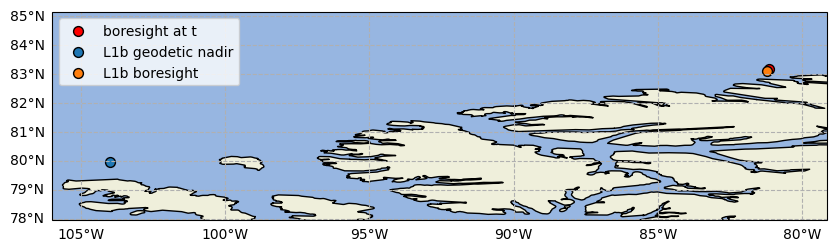

In [6]:
coordinates = [0,0,1]

plot_on_map(projection_to_earth_surface(coordinates), 1.)

## Here we plot the full pattern after the thresholding of the pattern 

It may be interesting here to play around with the thresholving values and see the result on the Earths surface. 

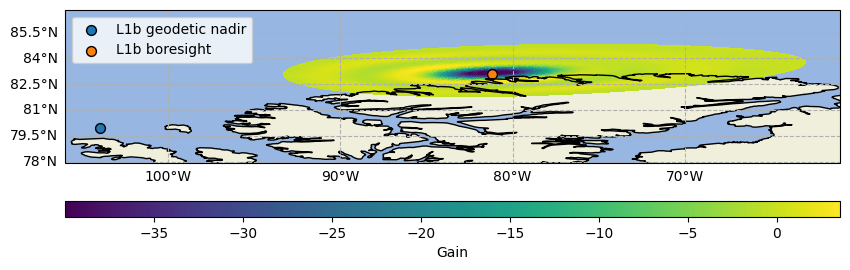

In [7]:
x, y, z, gains = get_antenna_patterns(antenna_file_path, 'G1h', phi_range=None, theta_range=[0,10], threshold=-40)

coordinates = np.array([x,y,z]).T

plot_on_map(projection_to_earth_surface(coordinates), gains)
